In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
import itertools

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
df_train = pd.read_csv('./data/sales_train.csv')
df_items = pd.read_csv('./data/items.csv')
df_shops = pd.read_csv('./data/shops.csv')
df_item_categories = pd.read_csv('./data/item_categories_kor.csv')
df_test = pd.read_csv('./data/test.csv')
df_submission = pd.read_csv('./data/sample_submission.csv')

# EDA : 매장관련
- 매장별 월간 판매 현황과 운영현황을 조사하기 위해 판매정보를 활용함.

In [3]:
# ## shp_cnt_mth: 가게 별 x 월 판매량
# train_shop = 1584 rows * 3 columns

train_shop = df_train.drop(columns=['date', 'item_id', 'item_price']) # 필요없는 열 제거
train_shop = train_shop.groupby(['date_block_num', 'shop_id']).sum('item_cnt_day').reset_index() # 월별 shop 판매량 계산
train_shop.rename(columns={'item_cnt_day':'shp_cnt_month'}, inplace=True)
train_shop

,date_block_num,shop_id,shp_cnt_month
0,0,0,5578.0
1,0,1,2947.0
2,0,2,1146.0
3,0,3,767.0
4,0,4,2114.0
...,...,...,...
1581,33,55,1972.0
1582,33,56,1263.0
1583,33,57,2316.0
1584,33,58,1446.0


- 월별 판매현황과 매장 운영 여부를 확인하기 위해 column을 월, index를 shop_id로 하여 월별 판매량을 피벗 테이블로 시각화함.

In [25]:
sales_by_shops = df_train.pivot_table(index='shop_id', values='item_cnt_day', 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0)
sales_by_shops

date_block_num,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
shop_id,,,,,,,,,,,,,,,,,,,,,
0,5578,6127,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2947,3364,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1146,488,753,583,553,832,807,875,945,795,...,987,907,762,859,843,804,785,942,822,727
3,767,798,959,647,710,784,721,890,1026,793,...,977,738,741,740,731,672,535,666,745,613
4,2114,2025,2060,285,1211,1464,1378,1713,1536,1482,...,1188,980,978,899,893,793,842,947,732,831
5,0,877,1355,1008,1110,1393,1265,1510,1298,1267,...,1404,1101,1109,1054,1012,954,991,1294,1092,1052
6,3686,4007,4519,3168,3022,3847,3360,3702,4208,3675,...,2328,2329,1981,1998,1748,1539,1484,1575,1725,1802
7,2495,2513,2460,1540,1647,2085,2031,2397,2599,2236,...,2084,1847,1430,1340,1217,1235,1327,1409,1287,1212
8,1463,1156,977,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- 해당 피벗테이블을 이용해 월별로 폐점, 개장, 영업하는 가게 등을 데이터 프레임 형식으로 나타냄.

In [10]:
sales_by_shops.reset_index(inplace=True)

# 누적 판매량이 없는 가게 목록: 누적 판매량이 0인 경우
shp_cnt_not_open = []
for i in range(34):
    li = sales_by_shops[sales_by_shops.loc[:,0:i].sum(axis=1)==0].shop_id.unique()
    shp_cnt_not_open.append(len(li))

# ### open_shp_mth:  월 별 개장 가게 수
open_shp_mth = [0]
for i in range(len(shp_cnt_not_open)-1):
    open_shp_mth.append(int(shp_cnt_not_open[i])-int(shp_cnt_not_open[i+1]))


# 더이상 판매량이 없는 가게 목록 : 월 판매량이 0 이하인 경우
shp_cnt_closed = []
for i in range(34):
    li = sales_by_shops[sales_by_shops.loc[:,i:].sum(axis=1)<=0].shop_id.unique()
    shp_cnt_closed.append(len(li))

# ### close_shp_mth: 월 별 폐점 가게 수
close_shp_mth = [0]
for i in range(len(shp_cnt_closed)-1):
    close_shp_mth.append(shp_cnt_closed[i+1] - shp_cnt_closed[i])
close_shp_mth[:10]

# ### shops_cnt : 영업중인 가게 수
shops_cnt = []
for i in range(34):
    temp = 60 - shp_cnt_not_open[i] - shp_cnt_closed[i]
    shops_cnt.append(temp)
    
df_shops = pd.DataFrame()
df_shops['date_block_num'] = np.arange(34)
df_shops['shp_cnt_not_open'] = shp_cnt_not_open
df_shops['open_shp_mth'] = open_shp_mth
df_shops['shp_cnt_closed'] = shp_cnt_closed
df_shops['close_shp_mth'] = close_shp_mth
df_shops['shops_cnt'] = shops_cnt
df_shops

,date_block_num,shp_cnt_not_open,open_shp_mth,shp_cnt_closed,close_shp_mth,shops_cnt
0,0,15,0,0,0,45
1,1,14,1,0,0,46
2,2,12,2,2,2,46
3,3,12,0,3,1,45
4,4,11,1,4,1,45
5,5,10,1,4,0,46
6,6,10,0,4,0,46
7,7,10,0,5,1,45
8,8,10,0,5,0,45
9,9,9,1,5,0,46


위 정보를 아래와 같이 시각화 함.
- ax1 : 월별 개장하는 가게와 폐장하는 가게 현황
- ax2 : 월별 전국 매장 운영 현황
- ax3 : 전체 정보

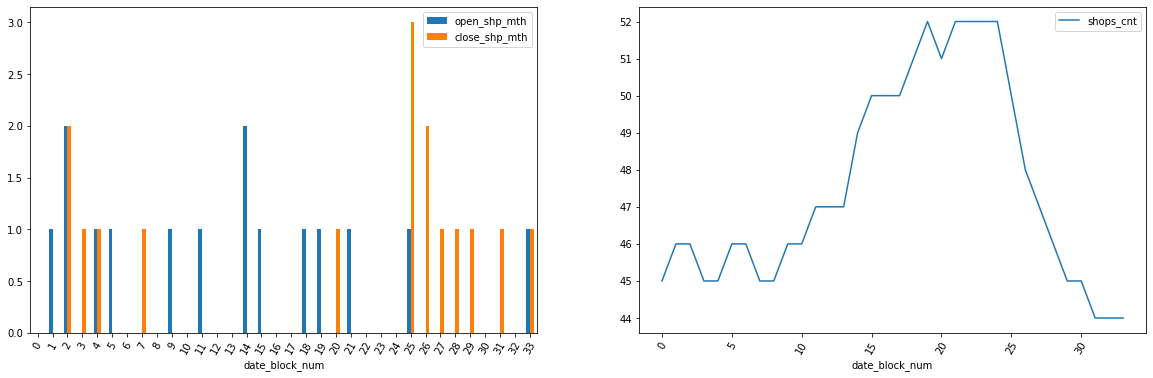

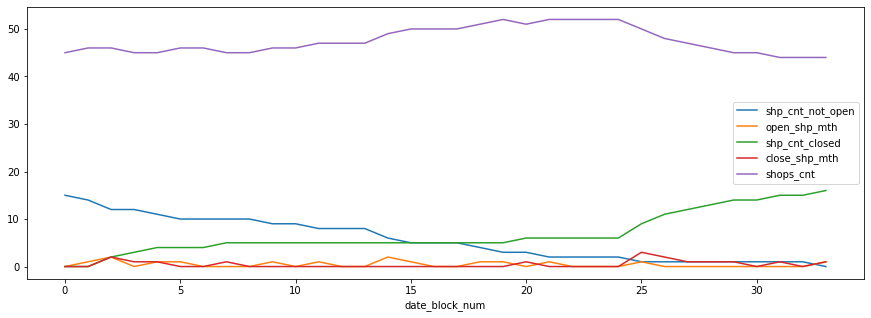

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6)) 

# 새로 생긴 가게 수
df_shops.plot(x='date_block_num', y=['open_shp_mth', 'close_shp_mth'], kind='bar', ax=ax1, rot=60)
# 영업중인 가게 수
df_shops.plot(x='date_block_num', y='shops_cnt', ax=ax2, rot=60)

df_shops.plot(x='date_block_num', figsize=(15,5))
plt.show()

# EDA: 카테고리 관련

- 전체 아이템 카테고리 83개의 판매현황을 알아보기 위해 각 카테고리별 월간 판매량을 계산하여 시각화로 나타냄.
- 카테고리 항목 중 이름에서 '-'를 기준으로 앞을 type_code, 뒤를 subtype_code로 구분하여 데이터 프레임에 추가함

In [38]:
cat1, cat2 = [], []
for n in df_item_categories.item_category_name:
    
    _ = n.split('-')
    cat1.append(_[0].strip())
    try: 
        cat2.append(_[1].strip())
    except:
        cat2.append(np.nan)
        
df_item_categories['type_code'] = cat1
df_item_categories['subtype_code'] = cat2

df_item_categories.head()

,item_category_name,item_category_id,type_code,subtype_code
0,PC - 헤드셋 / 헤드폰,0,PC,헤드셋 / 헤드폰
1,액세서리 - PS2.,1,액세서리,PS2.
2,액세서리 - PS3.,2,액세서리,PS3.
3,액세서리 - PS4.,3,액세서리,PS4.
4,액세서리 - PSP.,4,액세서리,PSP.


- 상위 20개 항목에 대하여 판매량을 나타내었을 때 40, 30, 55, 37, 19, 23, 37번 카테고리의 판매량이 두드러졌음.

total : 84


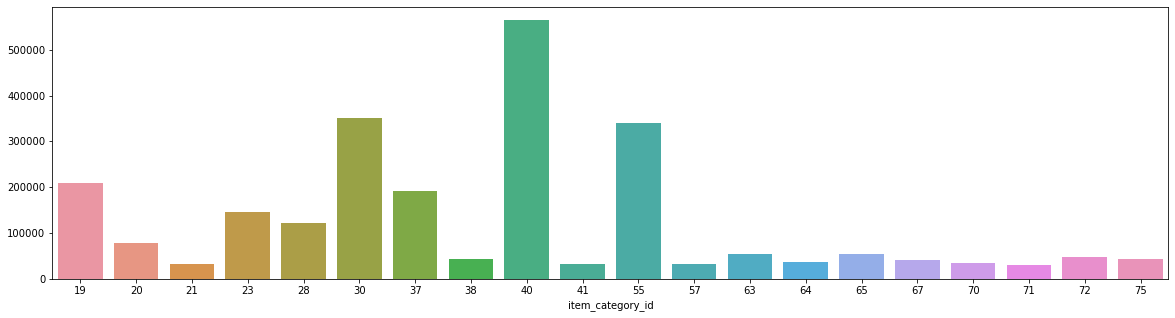

In [41]:
_ = pd.merge(left=df_item_categories, right=df_items, how='left')

sales_cat = pd.merge(left=df_train, right=_,
                    how='left', on='item_id')

# 컬럼 선별
var_list = ['date', 'date_block_num', 'item_category_id', 'item_cnt_day']

# 총 기간
period_t = sales_cat[var_list].groupby('item_category_id').apply(len)
print('total :', period_t.shape[0])
_ = period_t.nlargest(20)
plt.figure(figsize=(20,5))
sns.barplot(x=_.index, y=_.values)
plt.show()

- 위 7개 카테고리와 나머지로 구분하여 파이 차트로 나타낼 때 상위 7개 항목에서 전체량의 65%에 해당하는 비율을 차지하고 있음.

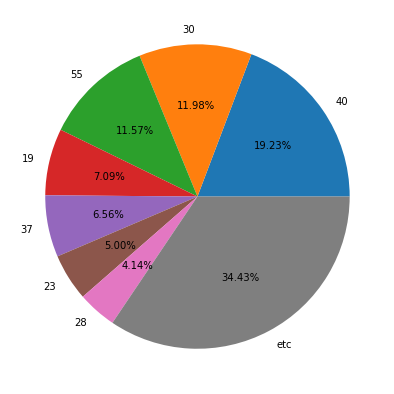

In [42]:
top7 = period_t.nlargest(7)
x = list(top7) + [period_t.sum() - top7.sum()]
y = list(top7.index) + ['etc']

plt.figure(figsize=(7,7))
plt.pie(x, labels=y, autopct='%.2f%%')
plt.show()

- 대분류로 나눈 그룹으로도 같은 방식의 시각화로 판매량을 조사해봄.
- 대분류는 21개 항목으로 구분되며 속한 카테고리의 수는 다음과 같음.

In [47]:
# type_code 개수
print('length :', len(df_item_categories.type_code.value_counts()))
df_item_categories.type_code.value_counts()

length : 21


책                      13
선물                     12
게임 콘솔                   8
게임                      8
액세서리                    7
프로그램                    6
음악                      6
지불 카드                   4
PC 게임                   4
시네마                     4
서비스                     2
클린 미디어 (조각)             1
클린 미디어 (첨탑)             1
PC                      1
필름                      1
지불 카드 (시네마, 음악, 게임)     1
맥 게임                    1
안드로이드 게임                1
상품 배달                   1
티켓 (숫자)                 1
전원 요소                   1
Name: type_code, dtype: int64

C:\Users\GW\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='type_code'>

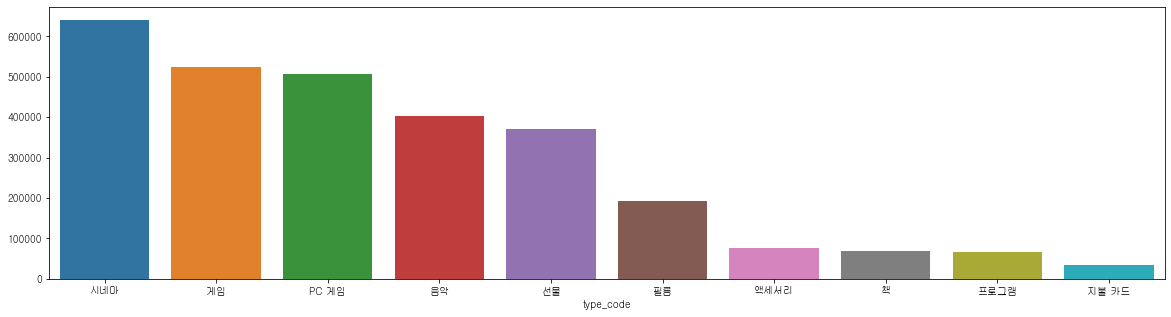

In [52]:
# 컬럼 선별
var_list = ['date', 'date_block_num', 'item_category_id', 'item_cnt_day', 'type_code']

# 총 기간
period_t = sales_cat[var_list].groupby('type_code').apply(len)
_ = period_t.nlargest(10)
plt.figure(figsize=(20,5))
sns.barplot(_.index, _.values)

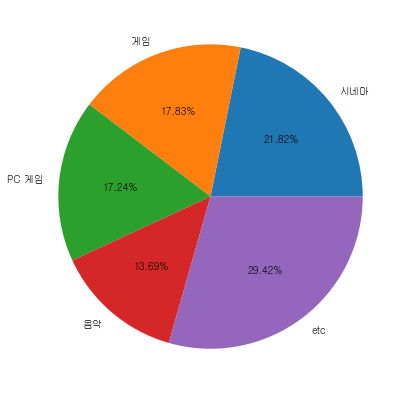

In [53]:
top7 = period_t.nlargest(4)
x = list(top7) + [period_t.sum() - top7.sum()]
y = list(top7.index) + ['etc']

plt.figure(figsize=(7,7))
plt.pie(x, labels=y, autopct='%.2f%%')
plt.show()

# EDA : 일자관련

- 일간 판매량을 알아보기 위해 판매량 데이터를 사용해 일간 평균 판매량을 계산함.(합산은 inf출력)
- 판매 데이터에서 date를 datetime형식으로 변환해 인덱스로 설정

In [ ]:
# date를 판다스 Timestamp로 변환. new_date 열에 저장.
df_train['new_date'] = pd.to_datetime(df_train['date'])

# date열 drop. (혹시 date열 사용하는 피처가 있다면 삭제안하면 됨)
df_train.drop('date', axis=1, inplace=True)

# 인덱스로 지정
df_train.set_index('new_date', inplace=True)

- datetime으로부터 요일을 추출하고 매장정보와 아이템정보를 포함해 matrix라는 새 데이터프레임을 만듦.

In [65]:
# 인덱스의 day로 부터 '요일'을 추출하여 새로운 열로 저장.
df_train['day of week'] = df_train.index.dayofweek

# 'day of week', 'shop_id', 'item_id'로 구성된 Matrix 만들기
ts = time.time()
matrix = []
cols = ['day of week', 'shop_id', 'item_id']
for i in range(7):
    sales = df_train[df_train['day of week'] == i]
    matrix.append(np.array(list(itertools.product(
        [i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['day of week'] = matrix['day of week'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)
time.time()-ts

6.92441463470459

- 먼저 요일별, 매장별, 아이템별 판매량의 합계를 구해 matrix에 추가함.

In [66]:
# df_train의 Groupby를 통한 요일별 Sales 구하기
group = df_train.groupby(['day of week', 'shop_id', 'item_id']).agg(
    {'item_cnt_day': ['sum']})

group.columns = ['item_cnt_day of week']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how='left')

matrix['item_cnt_day of week'] = (
    matrix['item_cnt_day of week'].fillna(0).clip(0, 30).astype(np.float16))
matrix

,day of week,shop_id,item_id,item_cnt_day of week
0,0,0,1,0.0
1,0,0,14,0.0
2,0,0,17,0.0
3,0,0,18,0.0
4,0,0,20,0.0
...,...,...,...,...
7187307,6,59,22164,1.0
7187308,6,59,22165,0.0
7187309,6,59,22166,0.0
7187310,6,59,22167,0.0


- 이후 요일별 판매량으로 계산해서 다음 bar plot으로 시각화함.
- 0-6은 각 월요일-일요일로, 평일에 판매량이 비슷하다 금요일부터 판매량이 상승하고 토요일에 피크점을 찍은 후 일요일날 다시 감소하는 추세를 볼 수 있었음.

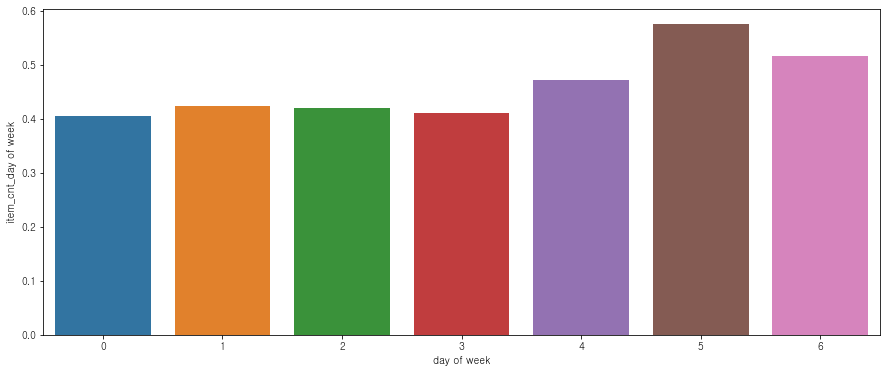

In [78]:
temp = matrix.groupby('day of week').agg({'item_cnt_day of week':'mean'}).reset_index()
plt.figure(figsize=(15,6))
sns.barplot(data=temp, x='day of week', y='item_cnt_day of week', )
plt.show()

# EDA : 매장위치 관련

- 각 매장들의 위경도정보는 다음과 같음

In [5]:
lat_lon = np.array([[62.02522883338076, 129.72024199904732],
        [62.037301616892094, 129.71780739602482],
        [45.01296654205926, 38.930381394697974],
        [55.79662072030961, 37.926708269234666],
        [48.77213659373243, 44.79983092746513],
        [59.19933176339063, 39.85963296975052],
        [51.6637860957119, 39.19722065453178],
        [51.69703307855997, 39.273326600570286],
        [51.78903488096228, 39.205010727554324],
        [51.6723172161094, 39.16413488151351],
        [55.59725083672762, 38.123644998835836],
        [55.59962715658703, 38.12065574116319],
        [55.74425126787867, 37.85613088382025],
        [55.86102167353668, 48.90016731558103],
        [55.83006084581892, 49.118158070006814],
        [54.51627336977013, 36.24648783160098],
        [55.084435206187386, 38.80062722765616],
        [56.034563392471625, 92.90775169884985],
        [56.037444791193835, 92.93459674303213],
        [51.73817162131831, 36.19237495424488],
        [51.749131378587414, 36.19165527111585],
        [55.749116642446964, 37.53971795116728],
        [55.753186031355504, 37.54463070833131],
        [55.758272274039825, 37.74128655991364],
        [55.75829214178443, 37.74124324086881],
        [55.75741804530215, 37.659152271555435],
        [55.643920792406774, 37.52642801202969],
        [55.65846529086957, 37.845193240865896],
        [55.60433461371562, 37.49193038319266],
        [55.737907223812826, 37.85703268319664],
        [55.892069619233105, 37.727542383201246],
        [55.78300780861633, 37.720300469705386],
        [55.785090401085675, 37.71250541388457],
        [55.902831039379166, 37.748112542321],
        [56.317923281992066, 43.9254617139005],
        [56.307479479513596, 44.074917042735976],
        [55.043900157462055, 82.92261732735507],
        [54.96361296533588, 82.93525796968106],
        [54.97212153272271, 73.28435824084553],
        [47.259882369829654, 39.71944439830313],
        [47.25986924888274, 39.719376814183626],
        [47.25554044000214, 39.7149579890257],
        [59.93186637067163, 30.35949391401205],
        [59.92526607201701, 30.320708956340265],
        [53.20921819087658, 50.13694424079427],
        [53.233070761246296, 50.20088826963057],
        [56.30443327161207, 38.13323056972107],
        [61.239532936829676, 73.37386898521791],
        [56.48875008598305, 84.97911338407611],
        [57.11763937726754, 65.54925082556653],
        [57.14895428030432, 65.5600427758361],
        [57.170099196344665, 65.56748255625473],
        [54.7365130520063, 55.956097856181835],
        [54.74994787441474, 56.00022231357387],
        [55.911296391178325, 37.396498027380815],
        [55.78148544779807, 37.61111228504873],
        [55.15357800870132, 37.45925219852253],
        [62.02519863718233, 129.72022054106412],
        [62.03154310580935, 129.74109877897183],
        [57.69792594741873, 39.758911854420106]])

In [6]:
df_shops['lat'] = lat_lon[:,0]
df_shops['lon'] = lat_lon[:,1]
df_shops.head()

,shop_name,shop_id,lat,lon
0,"!Якутск Орджоникидзе, 56 фран",0,62.025229,129.720242
1,"!Якутск ТЦ ""Центральный"" фран",1,62.037302,129.717807
2,"Адыгея ТЦ ""Мега""",2,45.012967,38.930381
3,"Балашиха ТРК ""Октябрь-Киномир""",3,55.796621,37.926708
4,"Волжский ТЦ ""Волга Молл""",4,48.772137,44.799831


- 매장별 판매량을 시각화하기 위해 판매정보를 사용.

In [14]:
sales_total = df_train.groupby(by= 'shop_id')['item_cnt_day'].sum()

shop = pd.concat([df_shops, sales_total], axis=1)
shop.rename(columns= {'item_cnt_day' : 'item_total_shop'}, inplace=True)
shop.head()

,shop_name,shop_id,lat,lon,item_total_shop
0,"!Якутск Орджоникидзе, 56 фран",0,62.025229,129.720242,11705.0
1,"!Якутск ТЦ ""Центральный"" фран",1,62.037302,129.717807,6311.0
2,"Адыгея ТЦ ""Мега""",2,45.012967,38.930381,30620.0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,55.796621,37.926708,28355.0
4,"Волжский ТЦ ""Волга Молл""",4,48.772137,44.799831,43942.0


In [18]:
import folium


# 지도객체 만들고 시작점 시작 배율 설정
russia =[shop['lat'].mean(), shop['lon'].mean()]
map_russia_shops = folium.Map(location = russia, zoom_start = 11)

# 지도 형식 변경
folium.TileLayer().add_to(map_russia_shops)

# 반복문 형식으로 여러 위경도 및 원형마크 표시
for i in range(len(shop)):
    name = shop['shop_name'][i]
    size = shop['item_total_shop'][i] / 10000
    lat = shop['lat'][i]
    lon = shop['lon'][i]
    folium.CircleMarker(location=[lat, lon], 
                        radius=size, color = 'red', 
                        popup=name).add_to(map_russia_shops)

map_russia_shops

In [19]:
# html 파일 형식으로 저장하기
map_russia_shops.save('./russia_shops.html')